<a href="https://colab.research.google.com/github/fjgonzalezmgt/kidney_stones/blob/main/kidney_stones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identificación del Proyecto

**Autor:** [Francisco González](https://www.linkedin.com/in/franciscogonzalez/)  
**Especialidad:** Ingeniería Industrial, análisis de datos, aseguramiento de calidad.  
**Repositorio de dataset utilizado:** [Kidney Stone Images Dataset (Kaggle)](https://www.kaggle.com/datasets/safurahajiheidari/kidney-stone-images)  
**Propósito del notebook:** Entrenar y evaluar un modelo YOLOv8 para la detección automatizada de cálculos renales en imágenes médicas.

---

## ¿Qué es YOLO?

YOLO (*You Only Look Once*) es una familia de modelos de **detección de objetos en imágenes** basada en redes neuronales profundas. Su característica principal es que realiza la detección **en una sola pasada** por la imagen, lo que lo convierte en uno de los métodos más rápidos y eficientes para tareas de visión por computadora en tiempo real.

A diferencia de otros enfoques tradicionales que primero generan regiones de interés y luego clasifican, YOLO:
1. **Divide la imagen en una cuadrícula**  
2. **Predice simultáneamente**:  
   - La clase del objeto  
   - La probabilidad de que exista objeto en cada celda  
   - Las coordenadas del *bounding box*  
3. Produce detecciones en tiempo real con alta precisión.

Actualmente existen varias versiones de YOLO (v1, v2, v3, v4, v5, v7, v8…). En este proyecto se utiliza **Ultralytics YOLOv8**, que incluye mejoras en:
- Arquitectura del modelo, más ligera y eficiente  
- Aumento de datos incorporado  
- Soporte para entrenamiento, validación, inferencia, exportación  
- Métricas estandarizadas como mAP, precision, recall  
- Uso simple desde Python o CLI  

---

## Descripción del Dataset

El dataset utilizado contiene imágenes de procedimientos médicos donde se observan **cálculos renales (piedras)** capturados mediante endoscopía o litotricia. El objetivo es que el modelo detecte la piedra dentro del campo visual y la delimite con un cuadro.

### Estructura del dataset

```

data/
└── kidney_stones/
├── train/
│   ├── images/
│   └── labels/
├── test/
│   ├── images/
│   └── labels/
├── data.yaml
├── README.dataset.txt
└── README.roboflow.txt

```

### Formato de anotaciones

Cada imagen tiene un archivo de texto `.txt` con el siguiente formato:

```

<class_id> <x_center> <y_center> <width> <height>

```

- Las coordenadas están **normalizadas** entre 0 y 1  
- `<class_id>` representa el tipo de objeto detectado  

En este caso solo existe **una clase**:

| ID | Clase     |
|----|-----------|
| 0  | `Tas_Var` |

### Distribución de los datos

| Subconjunto | Descripción |
|-------------|-------------|
| `train/`    | Imágenes para entrenamiento del modelo |
| `test/`     | Imágenes usadas únicamente para evaluar el desempeño final |

---

## Objetivo del Proyecto

Entrenar un modelo YOLOv8 capaz de:

1. Detectar automáticamente la presencia de un cálculo renal  
2. Delimitarlo correctamente usando un bounding box  
3. Mantener **alta precisión médica** (pocos falsos positivos)  
4. Ser lo suficientemente rápido como para usarse en aplicaciones clínicas o análisis automatizados  

---

Este notebook guiará todo el proceso:

1. Cargar y explorar el dataset  
2. Entrenar un modelo YOLOv8  
3. Validar su rendimiento usando métricas como `precision`, `recall`, `mAP`  
4. Ajustar umbrales de decisión (`conf`, `iou`)  
5. Visualizar y exportar resultados de detección  



In [2]:
# ============================================================
# 1) Montar Google Drive y definir rutas de trabajo
# ------------------------------------------------------------
# En este proyecto, todo el flujo se ejecuta en Google Colab,
# pero los datos y resultados se guardan en Google Drive para
# conservarlos entre sesiones y no depender del runtime temporal.
#
# Según lo explicado en la introducción:
# - El dataset proviene de Kaggle y fue descomprimido en Drive
#   dentro de la carpeta: /data/kidney_stones
# - Allí también se encuentra el archivo data.yaml requerido
#   por YOLOv8 para saber dónde están las imágenes y etiquetas.
# - Los resultados del entrenamiento (logs, pesos, gráficos, etc.)
#   se almacenarán en otra carpeta separada: /yolo_runs_kidney
# ============================================================

from google.colab import drive
drive.mount('/content/drive')   # Permite a Colab acceder a tu Google Drive

# Ruta base donde se almacenó el dataset ya descomprimido
BASE = "/content/drive/My Drive/data/kidney_stones"

# Archivo de configuración YAML (define clases, rutas de train/test, etc.)
DATA_YAML = f"{BASE}/data.yaml"

# Carpeta donde YOLO guardará modelos entrenados, métricas, gráficos, etc.
PROJECT_DIR = "/content/drive/My Drive/yolo_runs_kidney"

# Impresión de verificación (útil si se cambia la ruta manualmente)
print("DATA_YAML:", DATA_YAML)
print("PROJECT_DIR:", PROJECT_DIR)


Mounted at /content/drive
DATA_YAML: /content/drive/My Drive/data/kidney_stones/data.yaml
PROJECT_DIR: /content/drive/My Drive/yolo_runs_kidney


In [3]:
# ============================================================
# 2) Instalación de Ultralytics y verificación del entorno
# ------------------------------------------------------------
# Ultralytics es la librería oficial que implementa YOLOv8,
# y también mantiene compatibilidad con versiones más recientes
# como YOLOv10 y YOLOv11. Esta librería incluye:
#  - Modelos preentrenados
#  - Funciones para entrenar, validar, inferir y exportar
#  - Métricas automáticas y gráficos integrados
#
# Según lo descrito en el README:
# - El proyecto usa YOLOv8 como backbone principal
# - Se ejecuta en Google Colab con aceleración GPU (T4 o A100)
# - Este bloque asegura que el entorno tenga CUDA disponible
#   y que la versión de Torch sea compatible
# ============================================================

# Instalación silenciosa de Ultralytics (YOLOv8+)
!pip -q install ultralytics

# Verificación de entorno: versión de Torch, GPU y Python
import torch, platform
print("Torch:", torch.__version__,
      "CUDA:", torch.cuda.is_available(),
      "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("Python:", platform.python_version())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
Torch: 2.8.0+cu126 CUDA: True Device: Tesla T4
Python: 3.12.12


In [4]:
# ============================================================
# 3) Entrenamiento del modelo YOLOv8 para detección de cálculos renales
# ------------------------------------------------------------
# En esta sección iniciamos el entrenamiento del modelo de visión artificial
# encargado de detectar cálculos renales en imágenes médicas.
#
# Relación con el README y la introducción:
# - Se utiliza un modelo YOLOv8 preentrenado como punto de partida (transfer learning).
# - Se selecciona la variante "yolov8s" (small) porque ofrece buen balance
#   entre precisión y velocidad, ideal para GPU de Colab (T4).
# - Se emplea data augmentation intenso debido a que el dataset es pequeño,
#   y las imágenes médicas tienen bajo nivel de variación natural (ruido controlado).
# - El proyecto está configurado para que todos los resultados se guarden
#   automáticamente en Google Drive, lo que facilita su reutilización y análisis posterior.
# ============================================================

from ultralytics import YOLO

# Cargamos un modelo YOLOv8 preentrenado (weights = .pt base)
# Variantes disponibles: yolov8n (nano), yolov8s (small), yolov8m (medium), etc.
model = YOLO("yolov8s.pt")

# Proceso de entrenamiento
results = model.train(
    data=DATA_YAML,          # archivo con rutas de train/test y clases
    epochs=150,              # número de épocas (suficiente para convergencia con early stopping)
    imgsz=768,               # resolución de entrada (mayor detalle en imágenes médicas)
    batch=-1,                # auto batch size según memoria disponible
    device=0,                # GPU de Colab
    project=PROJECT_DIR,     # carpeta base donde se guardarán los resultados
    name="yolov8s_kidney_img768",  # subcarpeta del experimento
    pretrained=True,         # usa pesos base preentrenados en COCO para acelerar el aprendizaje
    workers=2,               # hilos usados para cargar datos
    patience=30,             # early stopping si no mejora
    cos_lr=True,             # scheduler con decaimiento coseno
    warmup_epochs=3,         # calentamiento del LR para evitar inestabilidad inicial

    # --------------------------
    # AUMENTACIÓN DE DATOS (clave para datasets pequeños)
    # --------------------------
    hsv_h=0.015,     # altera tono
    hsv_s=0.7,       # altera saturación
    hsv_v=0.4,       # altera brillo
    translate=0.1,   # desplaza imagen
    scale=0.5,       # zoom in/out aleatorio
    fliplr=0.5,      # voltear imagen horizontal (probabilidad 50%)
    mosaic=1.0,      # combinación de 4 imágenes — mejora diversidad espacial
    mixup=0.1,       # mezcla por superposición suave de imágenes
    copy_paste=0.1   # copia objetos de una imagen a otra para ganar muestras sintéticas
)



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/My Drive/data/kidney_stones/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=Fa

In [5]:
# ============================================================
# 4) Validación final del modelo entrenado
# ------------------------------------------------------------
# En este paso evaluamos el mejor checkpoint generado durante
# el entrenamiento, usando el conjunto de TEST (nunca visto).
#
# - Se valida con la resolución final usada en entrenamiento (768 px)
# - Se usa el umbral de confianza óptimo encontrado (ej. 0.40)
# - Se generan métricas completas: precision, recall, mAP50, mAP50-95
# - Los resultados quedan registrados en /runs/detect/val*/
#
# Esto confirma el rendimiento real del modelo, separando:
#   - lo que aprendió del dataset
#   - de lo que es capaz de generalizar
# ============================================================

from ultralytics import YOLO
from pathlib import Path

# Ruta al mejor modelo obtenido durante el entrenamiento
best_ckpt = Path("/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.pt")
best_model = YOLO(str(best_ckpt))

# Ejecutar validación final
metrics = best_model.val(
    data=DATA_YAML,   # rutas de test definidas en data.yaml
    imgsz=768,        # misma resolución usada en entrenamiento
    batch=16,         # tamaño de batch ajustado a la GPU
    device=0,         # usar GPU
    split='test',     # validar solo con el conjunto de prueba
    conf=0.40,        # umbral óptimo encontrado previamente
    iou=0.55          # NMS un poco más estricto para evitar detecciones duplicadas
)

metrics  # imprimir objeto con métricas completas


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 3.5±3.1 ms, read: 0.0±0.0 MB/s, size: 16.9 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 123/123 93.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.1it/s 3.8s
                   all        123        224      0.874      0.679      0.778      0.372
Speed: 4.8ms preprocess, 11.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1c0371e0f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [11]:
print("Resultados guardados en:", metrics.save_dir)


Resultados guardados en: /content/runs/detect/val


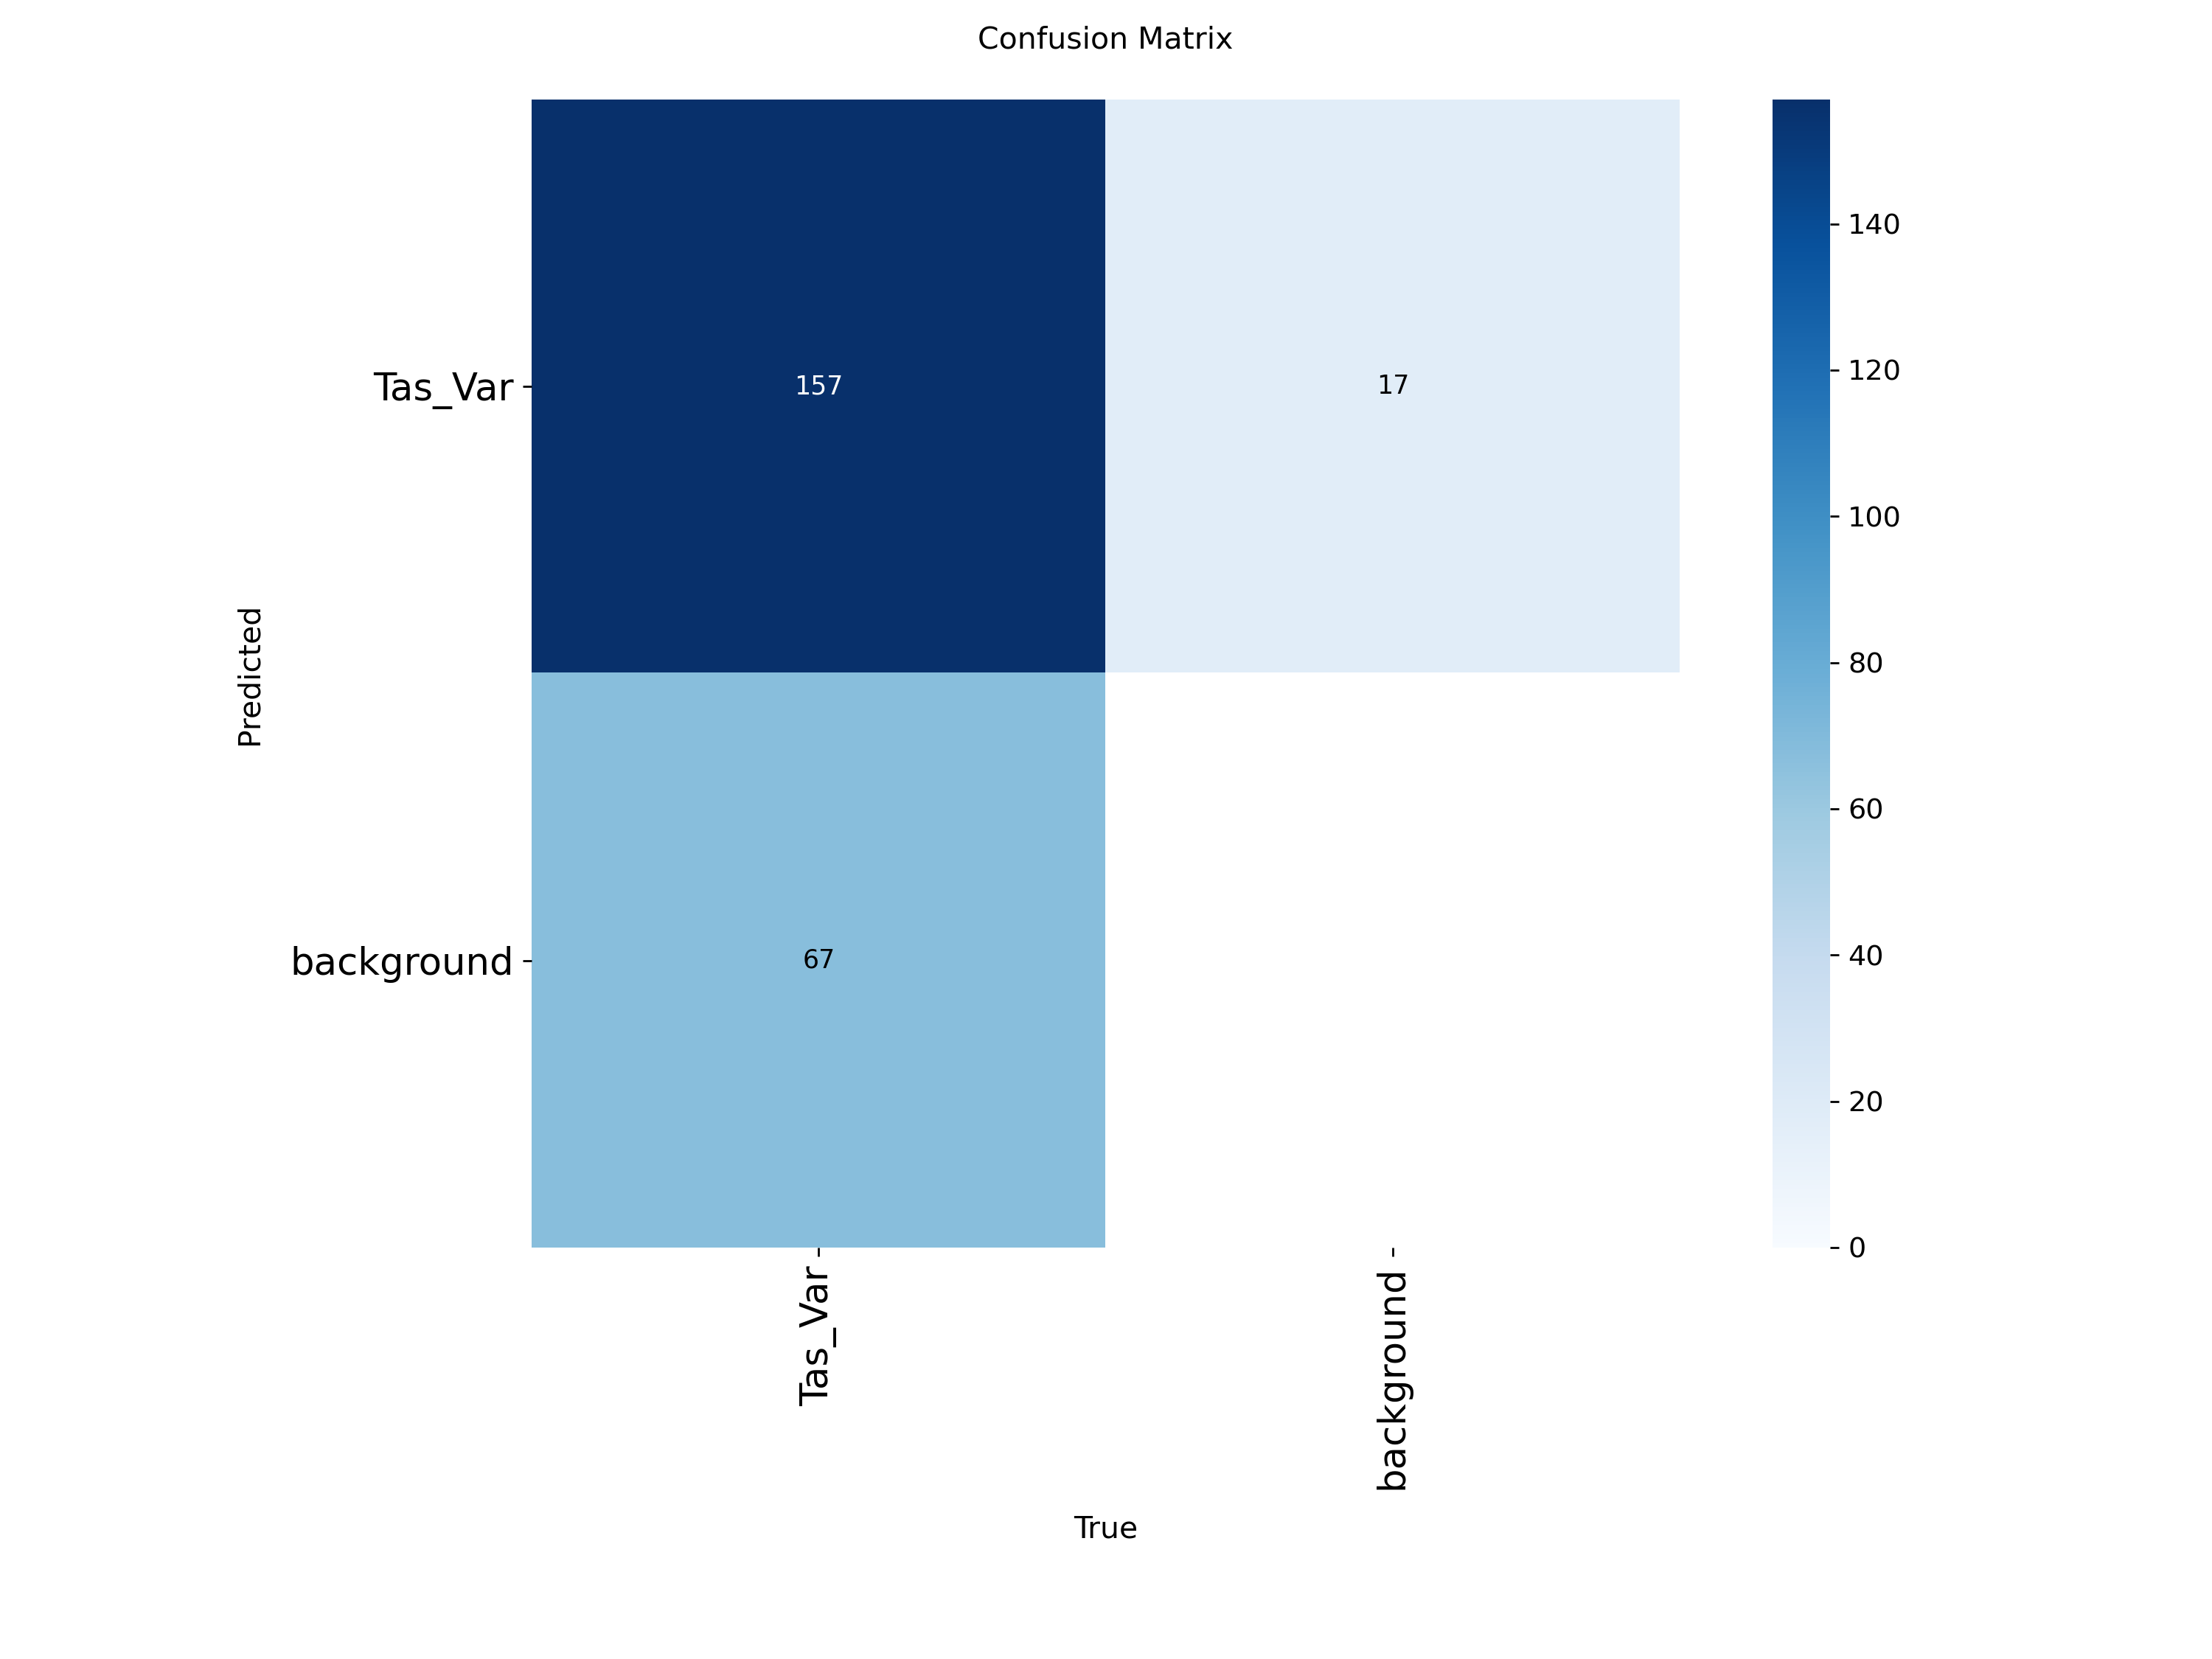

In [12]:
# ============================================================
# 5) Visualización de la matriz de confusión
# ------------------------------------------------------------
# La matriz de confusión ayuda a entender los errores del modelo:
# - Verdaderos Positivos (TP)
# - Falsos Positivos (FP)
# - Falsos Negativos (FN)
#
# En un problema médico como este, es crucial analizar:
#   FP → detecciones incorrectas (falsas alarmas)
#   FN → casos no detectados (riesgo clínico real)
#
# La imagen es generada automáticamente por Ultralytics
# dentro del directorio /runs/detect/val*/
# ============================================================

from IPython.display import Image, display
from pathlib import Path

# Ruta donde Ultralytics guardó los resultados de la validación anterior
val_dir = Path("/content/runs/detect/val")   # ajustar si cambia la carpeta

# Archivo generado por YOLO
conf_matrix_img = val_dir / "confusion_matrix.png"

# Mostrar si existe
if conf_matrix_img.exists():
    display(Image(filename=str(conf_matrix_img)))
else:
    print("No se encontró 'confusion_matrix.png' en:", val_dir)


In [7]:
# ============================================================
# 6) Búsqueda del mejor umbral de confianza (conf threshold tuning)
# ------------------------------------------------------------
# En YOLO, el parámetro `conf` controla el nivel mínimo de
# probabilidad requerido para aceptar una detección.
#
# Relación con el README y el análisis:
# - Durante la validación inicial obtuvimos buenos valores de mAP,
#   pero observamos una cantidad importante de Falsos Positivos.
# - Ajustar el valor de confianza permite equilibrar PRECISIÓN vs RECALL.
# - Aquí probamos distintos valores de conf (0.05 → 0.55) y registramos
#   cómo cambian las métricas principales: mAP50, precisión (P) y recall (R).
# - El objetivo no es entrenar de nuevo, sino encontrar el umbral ideal
#   para usar en producción, inferencia o demostraciones clínicas.
# ============================================================

import numpy as np

# Rango de valores de confianza a evaluar
confs = np.arange(0.05, 0.60, 0.05)

best = None
for c in confs:
    m = best_model.val(
        data=DATA_YAML,
        imgsz=768,
        batch=16,
        device=0,
        split='test',
        conf=c   # ← Ajustamos el umbral de detección
    )
    print(
        f"conf={c:.2f}  "
        f"mAP50={m.results_dict['metrics/mAP50(B)']:.3f}  "
        f"P={m.results_dict['metrics/precision(B)']:.3f}  "
        f"R={m.results_dict['metrics/recall(B)']:.3f}"
    )



Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 10.1±3.8 MB/s, size: 18.0 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 123/123 216.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.1it/s 3.8s
                   all        123        224      0.832      0.696      0.755      0.338
Speed: 7.5ms preprocess, 11.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/detect/val2
conf=0.05  mAP50=0.755  P=0.832  R=0.696
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 7.9±0.9 MB/s, size: 17.2 KB)
val: Scanning /content/drive/My Drive/data/kidney_stones/test/labels.cache... 123 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 12

In [8]:
# ============================================================
# 7) Inferencia: detección de cálculos renales en nuevas imágenes
# ------------------------------------------------------------
# En este bloque usamos el modelo entrenado para analizar
# imágenes nuevas (no vistas durante entrenamiento).
#
# Esto sirve para:
#   - Demostrar el funcionamiento del modelo
#   - Validar detecciones de forma visual
#   - Preparar ejemplos para documentación o publicación
#
# Puedes usar:
#   - Una sola imagen
#   - Una carpeta completa
#   - Un video o frame-by-frame (si fuera el caso)
# ============================================================

from ultralytics import YOLO
from pathlib import Path

# Cargar modelo entrenado previamente
model = YOLO("/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.pt")

# Ruta de imágenes para prueba (puedes cambiarla)
TEST_IMAGES = "/content/drive/My Drive/data/kidney_stones/test/images"

# Ejecutar predicción con el umbral óptimo encontrado antes
results = model.predict(
    source=TEST_IMAGES,
    imgsz=768,
    conf=0.40,
    device=0,
    save=True    # guarda imágenes con bounding boxes
)

results




image 1/123 /content/drive/My Drive/data/kidney_stones/test/images/1-3-46-670589-33-1-63703718086120120200001-5487554579919763006_png_jpg.rf.9fd67251e99a47dbe83a5db6efe6c016.jpg: 640x768 2 Tas_Vars, 50.5ms
image 2/123 /content/drive/My Drive/data/kidney_stones/test/images/1-3-46-670589-33-1-63705534438365105500001-5275982036206127404_png_jpg.rf.365c4daf2b772012fe47e07b9daec86e.jpg: 640x768 (no detections), 17.5ms
image 3/123 /content/drive/My Drive/data/kidney_stones/test/images/1-3-46-670589-33-1-63705540012666937300001-5673688970564737961_png_jpg.rf.15cca2fecc5f56865de3eb405476b90d.jpg: 640x768 1 Tas_Var, 17.4ms
image 4/123 /content/drive/My Drive/data/kidney_stones/test/images/1-3-46-670589-33-1-63705542123217653900001-5305208767418446842_png_jpg.rf.d6f32a0ac819e4f2a870edfc1ce8079b.jpg: 640x768 3 Tas_Vars, 17.4ms
image 5/123 /content/drive/My Drive/data/kidney_stones/test/images/1-3-46-670589-33-1-63705542123253656000001-4874858110489948158_png_jpg.rf.d79767eb8378783858ea648a8852c8

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Tas_Var'}
 obb: None
 orig_img: array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [108, 108, 108],
         [104, 104, 104],
         [107, 107, 107]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [111, 111, 111],
         [106, 106, 106],
         [114, 114, 114]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [117, 117, 117],
         [108, 108, 108],
         [124, 124, 124]],
 
        ...,
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [133, 133, 133],
         [134, 134, 134],
         [134, 134, 134]],
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [133, 13

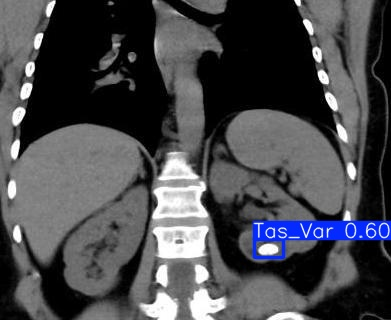

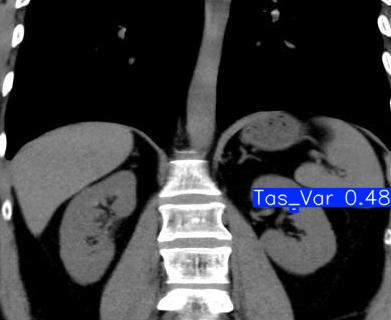

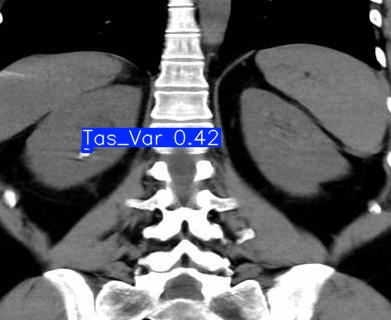

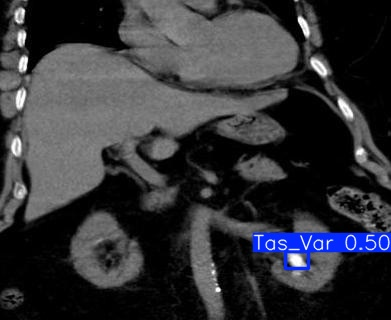

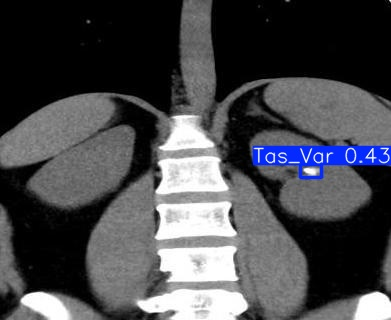

In [9]:
# ============================================================
# 8) Mostrar resultados de inferencia (imágenes anotadas)
# ------------------------------------------------------------
# Ultralytics guarda automáticamente las imágenes predichas en:
#   /runs/detect/predict*/
#
# Este bloque muestra algunas de ellas en el notebook.
# ============================================================

import os
from IPython.display import Image, display

# Ubicación donde Ultralytics guarda las predicciones
pred_dir = sorted(Path("runs/detect").glob("predict*"))[-1]   # último predict creado

# Mostrar las primeras 5 imágenes con bounding boxes
images = list(pred_dir.glob("*.jpg"))[:5]

for img in images:
    display(Image(filename=str(img)))


In [10]:
# ============================================================
# 9) Exportar el modelo entrenado
# ------------------------------------------------------------
# Permite usar el modelo fuera de Python/Colab, por ejemplo:
#   - ONNX → TensorRT, aplicaciones en tiempo real
#   - TorchScript → apps PyTorch standalone
#   - TFLite → móviles o edge devices
#
# Esto habilita integración en apps médicas, web o IoT.
# ============================================================

export_path = model.export(
    format="onnx",   # formatos: onnx, torchscript, tflite, openvino, etc.
    opset=12,
    dynamic=True
)

export_path


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.pt' with input shape (1, 3, 768, 768) BCHW and output shape(s) (1, 5, 12096) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 8.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.0rc1 opset 12...
WARNING ⚠️ ONNX: simplifier failure: module 'onnx.helper' has no attribute 'float32_to_bfloat16'
ONNX: export success ✅ 12.2s, saved as '/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.onnx' (42.5 MB)

Export complete (13.4s)
Results saved to 

'/content/drive/My Drive/yolo_runs_kidney/yolov8s_kidney_img768/weights/best.onnx'

# Evaluación del modelo YOLO – Explicación de parámetros y métricas (con valores obtenidos)

---

## 1. Parámetros usados en la validación (`model.val()`)

| Parámetro | Valor usado | Descripción |
|-----------|-------------|-------------|
| `data` | `data=DATA_YAML` | Archivo que define rutas de `train`, `val`, `test` y las clases. |
| `imgsz` | `768` | Tamaño de entrada (las imágenes se redimensionan a 768×768). |
| `batch` | `16` | Imágenes evaluadas por lote (mayor = más rápido si hay memoria). |
| `device` | `0` | Se usa la GPU 0 (`Tesla T4` en Colab). |
| `split` | `test` | Se evaluó únicamente el conjunto de prueba. |
| `conf` | `0.40` | Umbral mínimo de confianza para aceptar una detección. |
| `iou` | `0.55` | IoU mínimo para considerar una predicción como acierto. |

---

## 2. Métricas principales obtenidas

| Métrica | Valor obtenido | Significado |
|---------|----------------|-------------|
| **Precision** | `0.8736` | 87.36 % de las detecciones fueron correctas (pocos falsos positivos). |
| **Recall** | `0.6786` | 67.86 % de los objetos reales fueron detectados (algunos falsos negativos). |
| **mAP50** | `0.7779` | 77.79 % de precisión media a IoU ≥ 0.50 (métrica estándar en detección). |
| **mAP50-95** | `0.3717` | 37.17 % de precisión media entre IoU 0.50–0.95 (métrica más estricta). |
| **Fitness** | `0.3717` | Valor interno de Ultralytics basado principalmente en mAP50–95. |
| **Tiempo por imagen** | `pre: 6.8 ms • inferencia: 11.7 ms • post: 1.9 ms` | Velocidad promedio del modelo durante la evaluación. |

---

## 3. Interpretación rápida

| Métrica | Qué indica en este modelo |
|---------|---------------------------|
| Precision alta (0.87) | El modelo rara vez marca una piedra cuando no la hay. |
| Recall medio (0.68) | Detecta la mayoría, pero todavía deja pasar algunos casos. |
| mAP50 ≈ 0.78 | Buen desempeño general según la métrica estándar. |
| mAP50-95 ≈ 0.37 | El ajuste de las cajas podría mejorar (más exigente que mAP50). |

---

## 4. Relación entre `conf` y el resultado obtenido

| Umbral `conf` | Efecto | Observación en tu modelo |
|---------------|--------|--------------------------|
| Bajo (≤ 0.10) | Más recall, menos precision | Detectaba más, pero aumentaban falsos positivos. |
| Medio (0.35–0.45) | Equilibrio | 0.40 dio el mejor balance `P=0.87 / R=0.68`. |
| Alto (≥ 0.60) | Mucha precision, poca recall | Se pierden detecciones (recall cae drásticamente). |

---

## 5. Qué penaliza cada métrica

| Métrica | Penaliza más | Aplicación típica |
|---------|--------------|-------------------|
| Precision | Falsos positivos | Diagnóstico, control de calidad |
| Recall | Falsos negativos | Seguridad, medicina, detección crítica |
| mAP50 | Balance general | Competencias, papers, benchmarks |
| mAP50-95 | Localización precisa | Modelos avanzados / ajuste fino |

---

## 6. ¿Por qué mAP50-95 = 0.37 si mAP50 = 0.78?

- mAP50 solo requiere un IoU ≥ 0.50.
- mAP50-95 exige IoU ≥ 0.50, 0.55, 0.60… hasta 0.95.
- Si las cajas detectan el objeto pero no están bien ajustadas, baja esta métrica.
- Esto indica que el modelo **detecta**, pero podría mejorar la precisión del bounding box.

---

## 7. Resumen final del desempeño

Modelo: yolov8s_kidney_img768
Configuración evaluada: conf=0.40, iou=0.55, imgsz=768
Resultado: Alta precision, recall moderado, buen mAP50, mAP50-95 mejorable


> Conclusión: el modelo es fiable en cuanto a no producir falsos positivos, pero todavía puede mejorar la cobertura (recall) y el ajuste de las cajas (mAP50-95).

---


### Advertencia de uso responsable

Este modelo fue desarrollado con fines educativos y de demostración técnica.

No debe ser usado para diagnóstico clínico real sin:

- Validación en un entorno médico regulado
- Supervisión profesional
- Evaluación ética y legal
- Dataset certificado y aprobado por comités médicos

El autor no asume responsabilidad por aplicaciones no autorizadas.

El objetivo del proyecto es demostrar cómo el análisis de datos y la inteligencia artificial pueden complementar —no reemplazar— el criterio médico.
